<a href="https://colab.research.google.com/github/squirke1/ET5003/blob/main/Etivity_1_Stephen_Quirke_20172257.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div>
<img src="https://drive.google.com/uc?export=view&id=1vK33e_EqaHgBHcbRV_m38hx6IkG0blK_" width="350"/>
</div> 

#**Artificial Intelligence - MSc**
ET5003 - MACHINE LEARNING APPLICATIONS 

###Instructor: Enrique Naredo
###ET5003_Etivity-1

In [2]:
#@title Current Date
Today = '2021-09-19' #@param {type:"date"}


In [3]:
#@markdown ---
#@markdown ### Enter your details here:
Student_ID = "20172257" #@param {type:"string"}
Student_full_name = "Stephen Quirke" #@param {type:"string"}
#@markdown ---

In [4]:
#@title Notebook information
Notebook_type = 'Etivity' #@param ["Example", "Lab", "Practice", "Etivity", "Assignment", "Exam"]
Version = "Final" #@param ["Draft", "Final"]
Submission = True #@param {type:"boolean"}

#Introduction



## MNIST dataset



The MNIST database  is a dataset of handwritten digits that has been and is extensively used in machine learning. There are $10$ classes, each image is $28\times28$ pixels and, therefore, each input is $x_i\in\mathbb{R}^{784}$. 

## Task

You have to extend the code to manage any arbitrary number of classes, in other words you have to implement a general-recipe multinomial logistic classifier and Bayesian multinomial logistic classifier.

You must then select  3 digits at random and perform  the following task. 

1. Your goal is to use Bayesian multinomial logistic regression (as in the road-sign notebook) to solve this classification problem. 

2. You can downsize the training dataset (e.g., 40% training and 60%testing) if the computation of the posterior takes too much time in your computer.

3. Use the posterior uncertainty to detect the instances (digits) in the test set that are hard to classify and remove them from the test-set.

4. Then you need to compute again the accuracy of the general-recipe logistic regression on the remaining (non-difficult) instances and comment on the result.

5. In practice, the task is to use uncertainty estimation to detect the difficult instances in the test-set. This is equivalent to refuse to classify all high-uncertainty instances or, in other words, when we are uncertain we say "I don't know" and we do not return any class. In this way, you will learn how uncertainty can be used to make safer decisions, by detecting the instances that are difficult to classify.


## Libraries

In [5]:
# Suppressing Warnings:
import warnings
warnings.filterwarnings("ignore")

In [6]:
# Import libraries
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import scipy.optimize as optimize
from scipy.special import erf
import pandas as pd
import numpy as np
import seaborn as sns
from tqdm import tqdm
from skimage.io import imread, imshow
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import arviz as az
from scipy.io import loadmat
import pymc3 as pm
import random
from IPython.display import HTML
import pickle
import theano as tt
import cv2
from sklearn.utils import shuffle
from skimage.color import rgb2gray

In [7]:
plt.style.use('fivethirtyeight')

In [8]:
# Setting a seed:
np.random.seed(123)

## Dataset

### Loading the MNIST dataset

In [10]:
#Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [14]:
# Path, copy the path from your Drive
Path = '/content/drive/MyDrive/Colab Notebooks/ET5003_Etivity1/'

# MNIST Data
train_data = Path + 'mnist_train.csv'
test_data = Path + 'mnist_test.csv'

# train data
df_train = pd.read_csv(train_data)
X_train = df_train.drop("label",axis=1).values
y_train = df_train.label.values
print(X_train.shape)

# test data
df_test = pd.read_csv(test_data)
X_test = df_test.drop("label",axis=1).values
y_test = df_test.label.values
print(X_test.shape)

(60000, 784)
(10000, 784)


In [15]:
# Normalizing the Inputs:
X_train = X_train/255
X_test = X_test/255

# Printing the new input range of values:
minv = np.min(X_train)
maxv = np.max(X_train)
print(minv,maxv)

0.0 1.0


### Description of Data:

In [16]:
# Number of examples
n_train =  len(X_train)
n_test =  len(X_test)

# Shape of an traffic sign image
image_shape = X_train.shape[1]

# unique classes/labels in the training dataset.
alltotal = set(y_train)
n_classes = len(alltotal)

print("Number of Training examples =", n_train)
print("Number of Test examples =", n_test)
print("Image input shape =", image_shape)
print("Number of classes =", n_classes)

Number of Training examples = 60000
Number of Test examples = 10000
Image input shape = 784
Number of classes = 10


### Class Distribution:

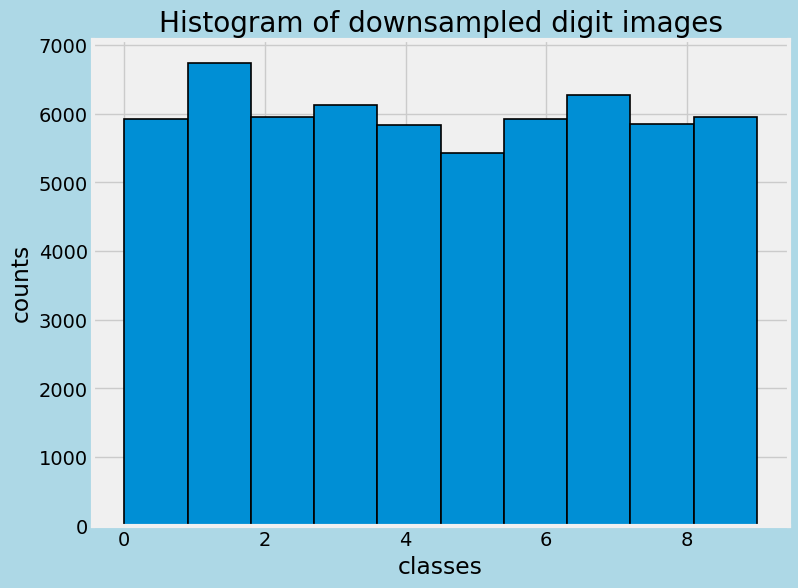

In [17]:
plt.figure(figsize=(8,6), dpi= 100, facecolor='lightblue', edgecolor='k')
plt.hist(y_train, bins=n_classes, edgecolor='black', linewidth=1.2)
plt.xlabel('classes')
plt.ylabel('counts')
plt.title('Histogram of downsampled digit images')
plt.show()

## Downsampling

### Randomly selecting 3 of the 10 Digit Classes

In [18]:
def select_number_of_classes(n_classes):
  """
  Returns an arbitrary random selection of digits 
  
  :param n_classes: arbitrary number of classes to be returned
  :return classes: random selection of group of classes totaling number specified
  """

  # Empty list to append the random digit classes we select:
  classes = []

  # We select 3 digits at random and make sure they are unique:
  while len(classes) < n_classes:
    
      # Randomly drawing a digit from 0-9:
      num2choose = np.random.randint(0,10)

      # Append the digit if it's not already in our list of classes:
      if num2choose not in classes: 
          classes.append(num2choose)
        
        
  # Sorting the Classes smallest to largest    
  classes.sort()

  # print classes selected
  print(classes)
  return classes

In [19]:
# Call select_number_of_classes function to return a group classes. In this instance, we want 3 classes as per the intructions
n_classes = 3
classes = select_number_of_classes(n_classes)

[1, 2, 6]


## Commentary:

As per the intructions, the code as  extended to code to handle an arbitrary number of classes by wrapping the logic to create a random group of digit classes in a function. NOTE: More logic needs to be added in order to make the code more resuable in order to make the solution more configurable to handle the requested number of classes.

In [20]:
# The number of instances we'll keep for each of our 3 digits:
inst_class = 5000

# List to contain inputs
inputs = []

# List to contain labels
labels = []

# Loop to randomly sample the instances for each digit:
for r in classes:
    imgs = X_train[np.where(y_train==r)[0],:]
    inputs.append(
        imgs[np.random.permutation(imgs.shape[0]),:][0:inst_class,:])
    labels.append(np.ones(inst_class)*r)
    
# Shaping inputs and labels in the right format    
X_train = np.vstack(inputs).astype(np.float64)
y_train = np.hstack(labels)

print(X_train.shape)

print(y_train.shape)

(15000, 784)
(15000,)


In [21]:
print(labels)

[array([1., 1., 1., ..., 1., 1., 1.]), array([2., 2., 2., ..., 2., 2., 2.]), array([6., 6., 6., ..., 6., 6., 6.])]


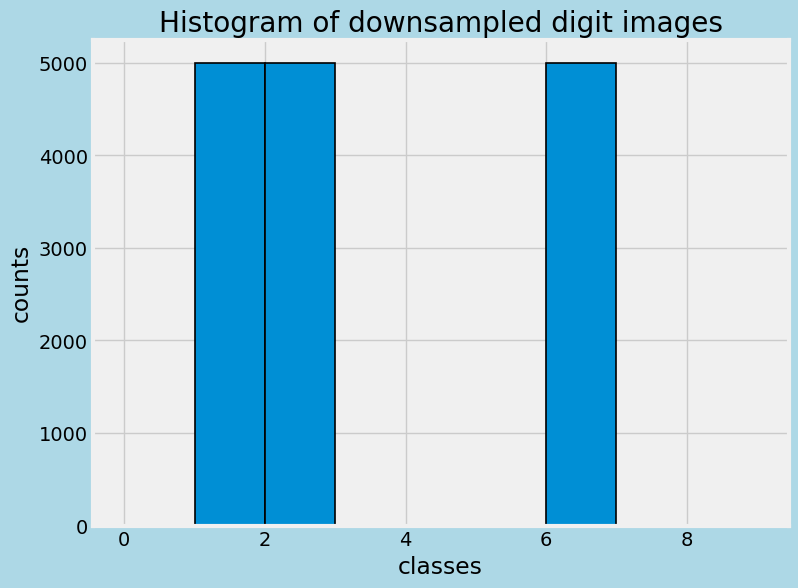

In [22]:
# new histogram
plt.figure(figsize=(8,6), dpi= 100, facecolor='lightblue', edgecolor='k')
plt.hist(y_train, bins=range(10), edgecolor='black', linewidth=1.2)
plt.xlabel('classes')
plt.ylabel('counts')
plt.title('Histogram of downsampled digit images')
plt.show()

New Classes Distribution

In [23]:
def plot_digits(instances, images_per_row=5, **options):
    """
    Plots digits as images.
  
    :param instances: array of digits to be plotted
    :param images_per_row: number of images per row to be plotted
    """
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image,  cmap='gist_yarg')
    plt.axis("off")

[ 1792  2252  2383  1873  3372  7155  7093  6244  7858  6909 14730 11056
 11956 11192 13797]


Text(0.5, 1.0, 'Original')

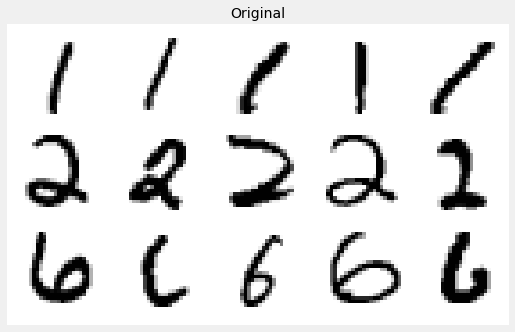

In [24]:
# Show a few instances from each Digit:
plt.figure(figsize=(8,8))

# Selecting a few label indices from each of the 3 classes to show:
label_indices = np.hstack([np.random.choice(np.where(y_train==label)[0], size=5) for label in classes])

print(label_indices)

# Plotting 'original' image
plot_digits(X_train[label_indices,:],images_per_row=5)
plt.title("Original", fontsize=14)

###  Splitting the Training data into both Training and Validation Sets:

- Although this is the Training set, we can still set aside some samples (for instance 20%) of the 1,500 instances we have for Model Validation purposes.


- With that Validation Set, we can then select the amount of Uncertainty we are happy with from our Model to use out of sample on other unseen data.


- We can then test out how well our decision performs on the Test Set that we put aside earlier.

In [25]:
### Split tha dataset in training and validation sets
# choose the fraction of your validation data from the training set
w = 0.20
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=w, random_state=0)
 
# Shuffling the training instaces around to randomize the order of inputs to the model:
X_train, y_train = shuffle(X_train, y_train)

In [26]:
# print shape of your validation and training set

print("Validation Shape: ", X_train.shape)
print("Training Shape: ", X_val.shape)

Validation Shape:  (12000, 784)
Training Shape:  (3000, 784)


### Encoding the Class labels for the Probabilistic ML Model:

This is an example:

- **[1,0,0]** for first digit
- **[0,1,0]** for second digit
- **[0,0,1]** for third digit

### General-Recipe ML

In [27]:
# model
model_log = LogisticRegression(random_state=0, max_iter=2000, C=100, solver='lbfgs', multi_class='multinomial')
model_log.fit(X_train, y_train)

# Classification:
y_pred_log = model_log.predict(X_val)
y_pred_logi_prob = model_log.predict_proba(X_val)

# Maybe taking the maximum probability 
# in any of the classes for each observation
prob_classmax = np.max(y_pred_logi_prob,axis=1)

# Computing the Accuracy:
print(f"Accuracy Score: {accuracy_score(y_pred_log, y_val)}")

Accuracy Score: 0.974


## Commentary

For the digit classess 0,1, and 9, we get a score of 0.992 which is an excellent result including hard to detect digits.

In [28]:
np.sort(prob_classmax)

array([0.42794286, 0.51281636, 0.51719572, ..., 1.        , 1.        ,
       1.        ])

In [29]:
# probability of general-recipe logistic regression in wrong instances
prob_classmax[y_pred_log!=y_val]
prob_classmax[y_pred_log!=y_val].shape

(78,)

In [30]:
np.array(y_pred_logi_prob)

array([[9.89326061e-01, 1.06739395e-02, 4.74380273e-12],
       [8.08042476e-31, 1.94425853e-09, 9.99999998e-01],
       [1.07712024e-18, 2.97203386e-08, 9.99999970e-01],
       ...,
       [4.55841060e-27, 1.11795929e-12, 1.00000000e+00],
       [2.78226471e-26, 1.00000000e+00, 1.87153181e-28],
       [9.99999944e-01, 5.59040672e-08, 1.31913574e-14]])

## Commentary

We get 24 intances of incorrect identification for the digit classes 0,1, and 9 from this run. out the 3000 validation set, 24 incorrect is a good return giving an accuracy of 99.2% as previously mentioned.

### Probabilistic Multinomial Logistic Regression:

In [31]:
import sklearn.preprocessing
## We use LabelBinarizer to transfor classes into counts
# neg_label=0, pos_label=1 
y_2_bin = sklearn.preprocessing.LabelBinarizer().fit_transform(y_train.reshape(-1,1))
nf = X_train.shape[1]
# number of classes
nc = len(classes)
# floatX = float32
floatX = tt.config.floatX

init_b = np.random.randn(nf, nc-1).astype(floatX)
init_a = np.random.randn(nc-1).astype(floatX)


with pm.Model() as multi_logistic:
    # Prior
    β = pm.Normal('beta', 0, sigma=100, shape=(nf, nc-1), testval=init_b)
    α = pm.Normal('alpha', 0, sigma=100, shape=(nc-1,), testval=init_a)
    
    # we need to consider nc-1 features because the model is not identifiable
    # the softmax turns a vector into a probability that sums up to one
    # therefore we add zeros to go back to dimension nc
    # so that softmax returns a vector of dimension nc
    β1  = tt.tensor.concatenate([np.zeros((nf,1)),β ],axis=1)
    α1  = tt.tensor.concatenate([[0],α ],)
    
    # Likelihood
    mu = pm.math.matrix_dot(X_train,β1) + α1
    # It doesn't work if the problem is binary
    p = tt.tensor.nnet.nnet.softmax(mu)
    observed = pm.Multinomial('likelihood', p=p, n=1, observed=y_2_bin)

The Multinomial Logistic Regression has some parameters:

- $\alpha$, which is the intercept term:

- $\beta$, which is a vector of coefficients which give a weighting to the importance of each input feature:


In [32]:
y_2_bin

array([[0, 0, 1],
       [1, 0, 0],
       [1, 0, 0],
       ...,
       [0, 1, 0],
       [1, 0, 0],
       [0, 0, 1]])

In [33]:
with multi_logistic:
    #approx = pm.fit(300000, method='advi') # takes longer
    approx = pm.fit(3000, method='advi')

WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.


Finished [100%]: Average Loss = 18,242


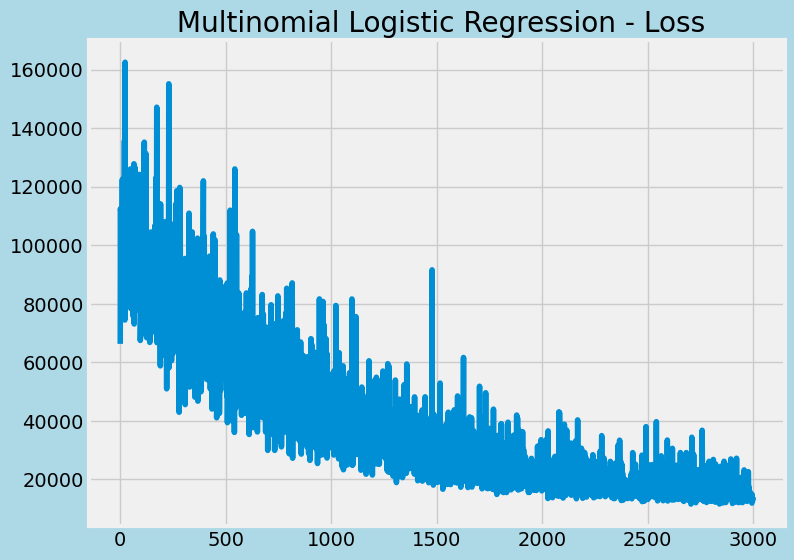

In [34]:
plt.figure(figsize=(8,6), dpi= 100, facecolor='lightblue', edgecolor='k')
plt.title(' Multinomial Logistic Regression - Loss')
plt.plot(approx.hist)

In [35]:
#https://docs.pymc.io/notebooks/variational_api_quickstart.html

from pymc3.variational.callbacks import CheckParametersConvergence

with multi_logistic:
    mean_field = pm.fit(3000, method="advi", callbacks=[pm.callbacks.CheckParametersConvergence(diff="absolute")]
    )

Finished [100%]: Average Loss = 17,837


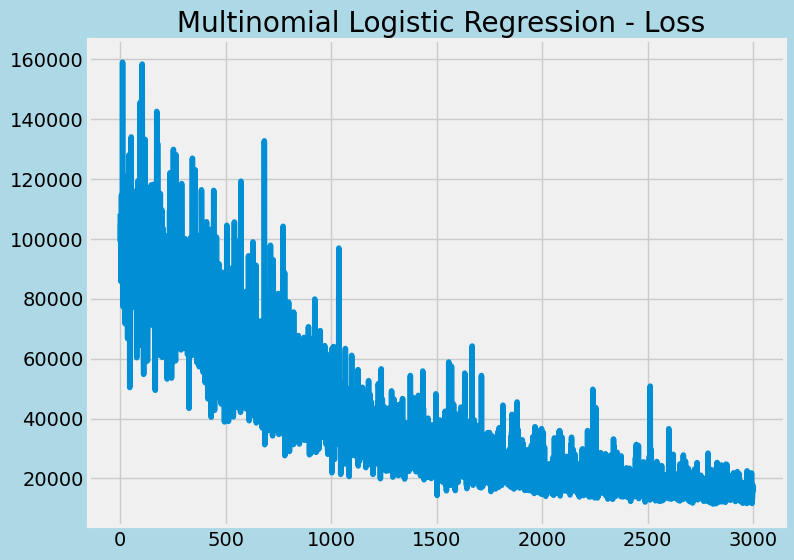

In [36]:
plt.figure(figsize=(8,6), dpi= 100, facecolor='lightblue', edgecolor='k')
plt.title(' Multinomial Logistic Regression - Loss')
plt.plot(mean_field.hist)

## Commentary:

We see plotted above the loss per iteration Multi Logistic Regression model the PyMC3 utomatic differentiation variational inference(ADVI) method. The average loss per iteration is 11,371 at 3000 iteration and we do not get a convergence at any stage.

In [37]:
dd = 300
posterior = approx.sample(draws=dd)

test image #10
posterior sample #100
true class= 6.0
classes: [1, 2, 6]
estimated prob= [0.0000004  0.98721599 0.0127836 ]


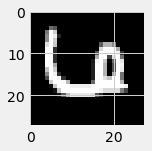

In [38]:
## The softmax function transforms each element of a collection by computing the exponential
#  of each element divided by the sum of the exponentials of all the elements.
from scipy.special import softmax

#select an image in the test set
i = 10 
#i = random.randint(0, dd)

#select a sample in the posterior
s = 100 
#s = random.randint(0, dd)

beta  = np.hstack([np.zeros((nf,1)),  posterior['beta'][s,:] ])
alpha = np.hstack([[0],  posterior['alpha'][s,:] ])
image = X_val[i,:].reshape(28,28)
plt.figure(figsize=(2,2))
plt.imshow(image,cmap="Greys_r")
np.set_printoptions(suppress=True)

print("test image #" + str(i))
print("posterior sample #" + str(s))
print("true class=", y_val[i])
print("classes: " + str(classes))
print("estimated prob=",softmax((np.array([X_val[i,:].dot(beta) + alpha])))[0,:])

## Bayesian Prediction

In [39]:
# Bayesian prediction
# return the class that has the highest posterior probability
y_pred_Bayesian=[]

for i in range(X_val.shape[0]):
    val=np.zeros((1,len(classes)))
    
    for s in range(posterior['beta'].shape[0]):
        beta = np.hstack([np.zeros((nf,1)),  posterior['beta'][s,:] ])
        alpha = np.hstack([[0],  posterior['alpha'][s,:] ])     
        val = val + softmax((np.array([X_val[i,:].dot(beta) + alpha])))
    
    mean_probability = val/posterior['beta'].shape[0]
    y_pred_Bayesian.append( np.argmax(mean_probability))

In [40]:
print(y_pred_Bayesian)

[0, 2, 1, 0, 1, 0, 2, 2, 1, 0, 1, 1, 0, 2, 0, 2, 0, 2, 2, 1, 2, 1, 1, 0, 0, 0, 2, 1, 1, 1, 1, 2, 1, 0, 2, 1, 2, 1, 2, 1, 2, 1, 2, 2, 0, 2, 1, 2, 2, 2, 2, 2, 1, 2, 1, 0, 0, 0, 2, 1, 2, 2, 1, 1, 1, 2, 1, 1, 1, 0, 2, 0, 1, 0, 2, 2, 1, 2, 1, 2, 2, 0, 0, 1, 2, 2, 2, 2, 1, 0, 1, 0, 0, 1, 2, 0, 2, 2, 0, 1, 1, 0, 1, 2, 1, 2, 0, 2, 2, 0, 0, 2, 1, 1, 1, 0, 2, 0, 1, 2, 2, 1, 0, 2, 0, 0, 0, 0, 2, 2, 2, 1, 1, 2, 2, 1, 2, 0, 1, 0, 1, 2, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 2, 0, 0, 1, 0, 1, 2, 0, 0, 0, 1, 1, 2, 1, 2, 2, 2, 2, 0, 2, 1, 1, 2, 1, 2, 1, 2, 0, 0, 2, 2, 1, 2, 2, 0, 1, 2, 2, 1, 0, 0, 0, 2, 1, 1, 2, 1, 0, 2, 0, 2, 1, 2, 1, 2, 2, 0, 1, 0, 0, 2, 0, 1, 0, 1, 2, 2, 0, 0, 1, 2, 2, 2, 2, 2, 2, 1, 0, 2, 0, 0, 2, 1, 2, 1, 2, 2, 2, 2, 0, 1, 0, 0, 1, 1, 1, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 0, 1, 2, 1, 1, 1, 0, 0, 0, 0, 2, 2, 2, 1, 2, 0, 1, 2, 2, 0, 1, 1, 0, 2, 0, 2, 1, 1, 0, 0, 1, 2, 0, 0, 1, 1, 1, 1, 0, 0, 2, 2, 1, 1, 2, 1, 0, 0, 0, 2, 0, 2, 2, 0, 0, 1, 0, 0, 2, 1, 2, 0, 2, 0, 2, 1, 1, 2, 1, 2, 2, 

In [41]:
print(classes)

[1, 2, 6]


In [42]:
# prediction array (using classes)
nn = 10 # just an example
np.array(classes)[y_pred_Bayesian[0:nn]]

array([1, 6, 2, 1, 2, 1, 6, 6, 2, 1])

In [43]:
# using validation: y_val
print("Accuracy=", accuracy_score(np.array(classes)[y_pred_Bayesian], y_val))

Accuracy= 0.9323333333333333


# Selecting Different Intances

In [44]:
y_predB=[]

for i in range(X_val.shape[0]):
    #print(i)
    val=[]

    for s in range(posterior['beta'].shape[0]):
        beta = np.hstack([np.zeros((nf,1)),  posterior['beta'][s,:] ])
        alpha = np.hstack([[0],  posterior['alpha'][s,:] ])
        val.append(softmax((np.array([X_val[i,:].dot(beta) + alpha])))[0,:])

    #mean probability
    valmean = np.mean(val,axis=0)
    #class with maximum mean probability
    classmax = np.argmax(valmean)
    #ranks
    ranks = np.array(val.copy())
    ranks   = ranks  *0 #init
    colmax = np.argmax(np.array(val),axis=1)
    ranks[np.arange(0,len(colmax)),colmax]=1
     
    y_predB.append( [classmax, valmean[classmax], np.std(ranks,axis=0)[classmax]])

    
y_predB= np.array(y_predB)

In [45]:
# prediction array
mm = 10
y_predB[0:mm,:]

array([[0.        , 0.95211705, 0.18794207],
       [2.        , 0.96959745, 0.16110728],
       [1.        , 0.53928668, 0.49909919],
       [0.        , 0.99708642, 0.        ],
       [1.        , 0.90018732, 0.29550334],
       [0.        , 0.65509047, 0.46249324],
       [2.        , 0.99231056, 0.08137704],
       [2.        , 0.82714481, 0.36348621],
       [1.        , 0.80246765, 0.3923009 ],
       [0.        , 0.94246321, 0.17058722]])

In [46]:
#sorting in descending order
difficult = np.argsort(-y_predB[:,2])
y_predB[difficult[0:mm],:]

array([[1.        , 0.50099441, 0.5       ],
       [2.        , 0.50892038, 0.5       ],
       [2.        , 0.47972264, 0.5       ],
       [2.        , 0.48477927, 0.5       ],
       [1.        , 0.49253461, 0.49998889],
       [0.        , 0.48186964, 0.49998889],
       [0.        , 0.50427488, 0.49998889],
       [0.        , 0.49348673, 0.49995555],
       [2.        , 0.48597312, 0.49995555],
       [2.        , 0.48994282, 0.49995555]])

In [47]:
print(len(difficult))

3000


In [48]:
#probability of general-recipe logistic regression in wrong instances
prob_classmax[y_pred_log != y_val]

array([1.        , 0.9999908 , 0.99995913, 0.99981316, 0.98083271,
       0.93160836, 0.87121878, 0.97077793, 0.99999997, 0.51281636,
       0.92647668, 0.99915538, 0.68446507, 0.99888272, 1.        ,
       0.58892699, 0.93712594, 0.99980657, 0.92448369, 0.86436716,
       0.99999999, 0.74991378, 0.99999971, 0.99946851, 0.9999984 ,
       0.98467027, 0.99772893, 0.99996555, 0.99977217, 0.8898859 ,
       0.85500602, 0.74938554, 0.96669718, 0.97653811, 0.67285204,
       0.6364302 , 0.95327147, 0.96538917, 0.96006529, 1.        ,
       0.99700056, 0.99951839, 0.97160668, 0.63319014, 0.99832596,
       0.98802452, 0.95566242, 0.97789359, 0.68066048, 0.99953724,
       0.93553806, 0.99999203, 0.99911984, 0.52529238, 0.99512415,
       0.99999959, 1.        , 0.9619594 , 0.89507795, 0.8648585 ,
       0.99528907, 0.60178173, 0.67797444, 0.9999999 , 0.98789771,
       1.        , 0.42794286, 0.97469632, 0.99839468, 0.9593731 ,
       0.99944375, 0.99566402, 0.66629481, 0.67123903, 0.97812

In [49]:
y_predB[y_pred_log != y_val,:]

array([[1.        , 0.90136104, 0.29089899],
       [2.        , 0.62972732, 0.47590849],
       [2.        , 0.74714072, 0.42909465],
       [1.        , 0.53364129, 0.49781746],
       [2.        , 0.56505258, 0.49638695],
       [1.        , 0.63722249, 0.47901519],
       [2.        , 0.80689161, 0.4       ],
       [0.        , 0.82035011, 0.35377331],
       [2.        , 0.77619033, 0.4142463 ],
       [0.        , 0.8129695 , 0.37853519],
       [1.        , 0.99396963, 0.08137704],
       [2.        , 0.75237577, 0.4330127 ],
       [1.        , 0.97359564, 0.1280191 ],
       [2.        , 0.66165447, 0.47256981],
       [2.        , 0.94212298, 0.20360637],
       [0.        , 0.47831467, 0.49888765],
       [1.        , 0.69581724, 0.44899889],
       [2.        , 0.51013213, 0.49972215],
       [0.        , 0.54292517, 0.49714742],
       [1.        , 0.56860583, 0.49355851],
       [1.        , 0.821584  , 0.37853519],
       [1.        , 0.48015999, 0.49972215],
       [2.

In [50]:
## Difficult & easy instances

easy = np.argsort(y_predB[:,2])
print("Accuracy in easy instances =", accuracy_score(y_pred_log[easy[0:100]], y_val[easy[0:100]]))

difficult = np.argsort(-y_predB[:,2])
print("Accuracy in difficult instances =", accuracy_score(y_pred_log[difficult[0:100]], y_val[difficult[0:100]]))

Accuracy in easy instances = 1.0
Accuracy in difficult instances = 0.91


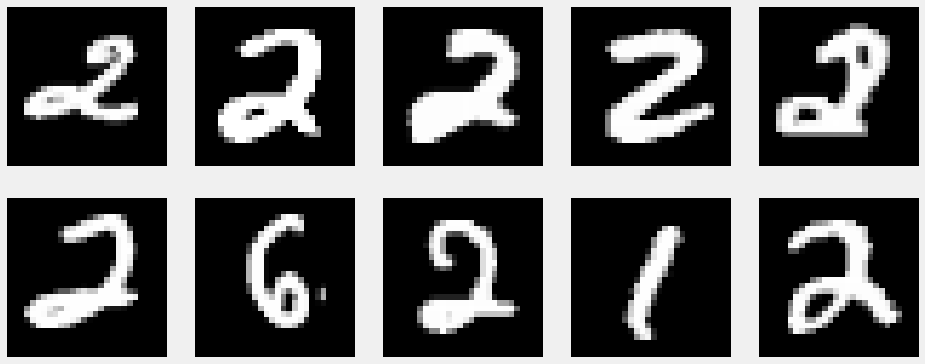

In [51]:
# show 10 random 'easy' images
fig, axs = plt.subplots(2,5, figsize=(15, 6))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()

for i in range(10):
    index = easy[i]
    image = X_val[index,:].reshape(28,28)
    axs[i].axis('off')
    axs[i].imshow(image,cmap="Greys_r")
    

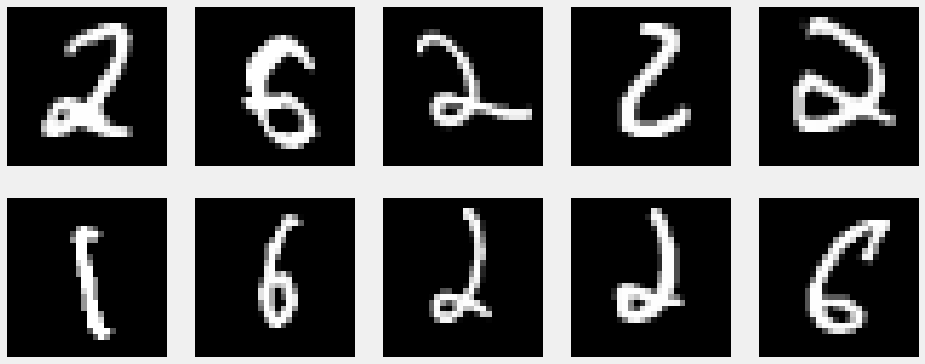

In [52]:
# show 10 random 'difficult' images
fig, axs = plt.subplots(2,5, figsize=(15, 6))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()
for i in range(10):
    index = difficult[i]
    image = X_val[index,:].reshape(28,28)
    axs[i].axis('off')
    axs[i].imshow(image,cmap="Greys_r")
    

## Commentary

We can visually see the hard to identify digits here. One of the 0;s for example does not have closed loop and another one has a thick font that does not appear circular. We still see a good accuracy score on the difficult to identify cases at 94% but for this exercise we want to achieve 100% accuracy and not missify any classes.

## Summary

Populate this section with all of your findings and comments fron the discussion with your peers.

In [53]:
%%capture
!wget -nc https://raw.githubusercontent.com/brpy/colab-pdf/master/colab_pdf.py
from colab_pdf import colab_pdf
colab_pdf('Etivity_1_Stephen_Quirke_20172257.ipynb')